In [2]:
cd ../..

/home/msi/projects/diplomka


In [3]:
import numpy as np 

In [4]:
import pandas as pd
import pathlib
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import copy

In [5]:
from pyod.models import cblof
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.mcd import MCD


In [6]:
models = [
    ABOD(contamination=0.01, n_neighbors=5),
    cblof.CBLOF(contamination=0.01),
    HBOS(contamination=0.01),
    IForest(contamination=0.01),
    KNN(contamination=0.01),
    LOF(contamination=0.01),
    # MCD(contamination=0.01, support_fraction=0.5),
    PCA(contamination=0.01),
]

In [12]:
dataset = glob.glob("results/benchmark/RTT/*.csv", recursive=True)
benchmark_dir = pathlib.Path('results/benchmark/')

In [8]:
def load_df(path):
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'] if 'timestamp' in df.columns else df['index'])
    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]

    return df

In [9]:
model_names =list(map(lambda x: x.__class__.__name__, models))

In [10]:
stats = pd.DataFrame(
    columns= ['num_samples', 'NormalModel_contamination',  'NormalModel_time']+[f"{model}_{stat}" for model in model_names for stat in ['contamination', 'precision', 'recall','specificity', 'f1', 'geometric', 'iba', 'time']],
    index = dataset
)

In [11]:
from trct.models import NormalModel

In [12]:
df = load_df(dataset[1])

In [13]:
import imblearn as imb

In [14]:
from tqdm import tqdm

In [15]:
def process(df, file_name):
    temp = df.copy()
    nm = NormalModel('a', 'b', gamma=1, sigma_factor=3, one_sided=False)
    
    stats.loc[file_name, 'num_samples'] = df.shape[0]

    start = datetime.now()
    for t, x in df['rtt'].items():
        nm.log(t.timestamp()*1000, x)
    end = datetime.now()
    nm_stat = nm.to_frame()['anomalies']

    stats.loc[file_name, 'NormalModel_contamination'] = nm_stat.sum()/len(nm_stat) 
    stats.loc[file_name, 'NormalModel_time'] = (end-start).total_seconds()

    temp['normalmodel_anomalies'] = nm.to_frame()['anomalies']
    
    for model in models:
        model_name = model.__class__.__name__
        model = copy.deepcopy(model)
        start = datetime.now()
        model.fit(df['rtt'].values.reshape(-1, 1))
        temp[f'{model_name}_anomalies'] = pred = model.predict(df['rtt'].values.reshape(-1, 1))
        end = datetime.now()
        stats.loc[file_name, f'{model_name}_time'] = (end-start).total_seconds()
        stats.loc[file_name, f'{model_name}_contamination'] = pred.sum()/len(pred)

        metrics = imb.metrics.classification_report_imbalanced(pred, nm_stat, output_dict=True)
        # print(metrics)
        stats.loc[file_name, f'{model_name}_precision'] = metrics['avg_pre']
        stats.loc[file_name, f'{model_name}_recall'] = metrics['avg_rec']
        stats.loc[file_name, f'{model_name}_specificity'] = metrics['avg_spe']
        stats.loc[file_name, f'{model_name}_f1'] = metrics['avg_f1']
        stats.loc[file_name, f'{model_name}_geometric'] = metrics['avg_geo']
        stats.loc[file_name, f'{model_name}_iba'] = metrics['avg_iba']




In [16]:
# process(df, dataset[1])

In [17]:
for file_path in tqdm(dataset):
    df = load_df(file_path)
    process(df, file_path)

  0%|          | 0/19 [00:00<?, ?it/s]/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
  5%|▌         | 1/19 [00:18<05:24, 18.05s/it]/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._v

: 

In [ ]:
from IPython.display import HTML

In [ ]:
import pathlib

<Figure size 2000x300 with 0 Axes>

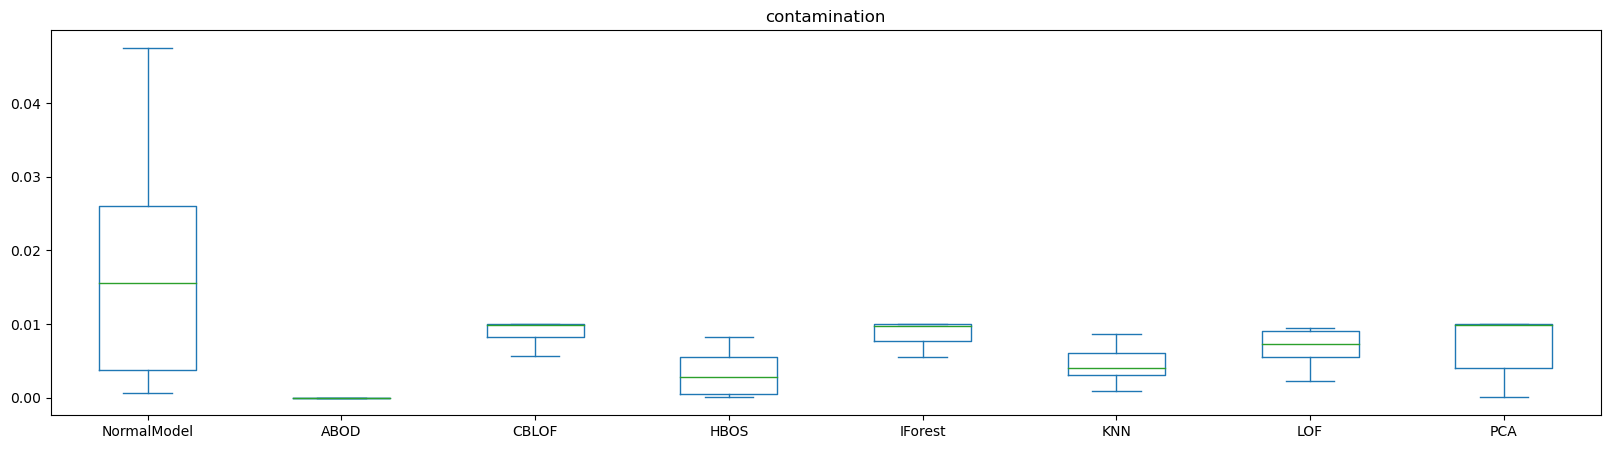

<Figure size 2000x300 with 0 Axes>

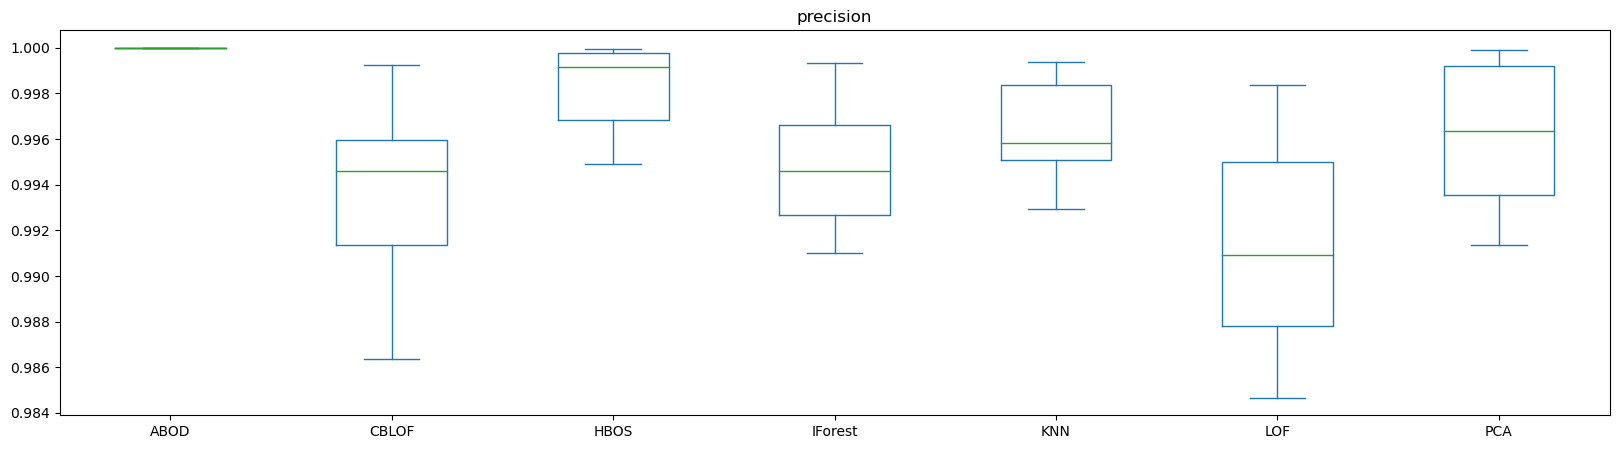

<Figure size 2000x300 with 0 Axes>

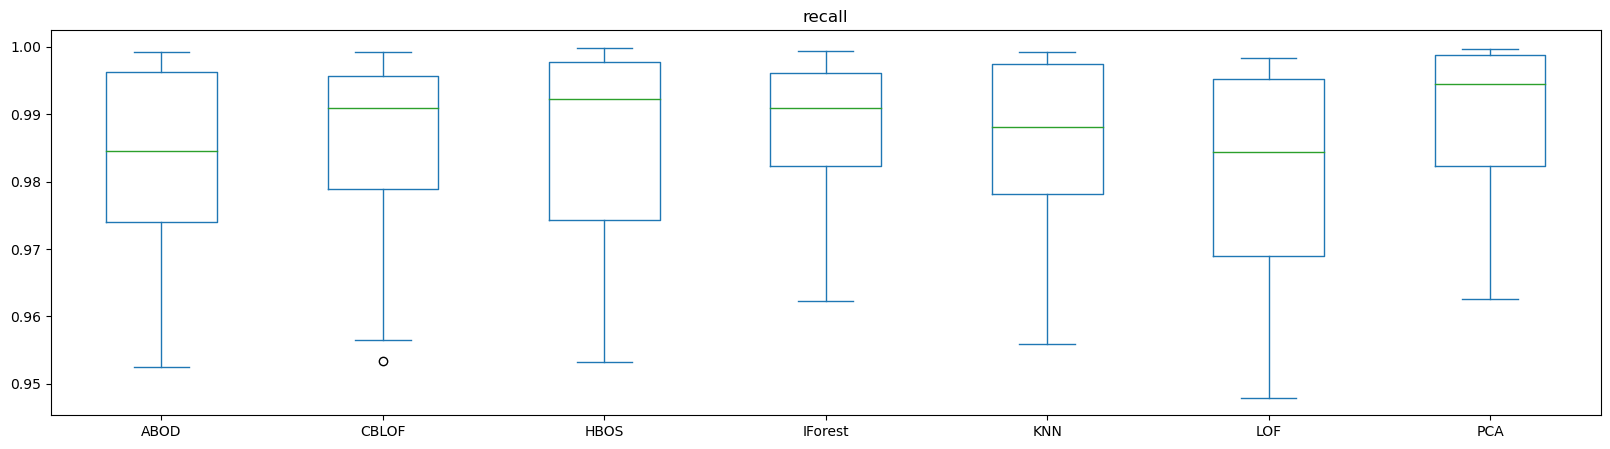

<Figure size 2000x300 with 0 Axes>

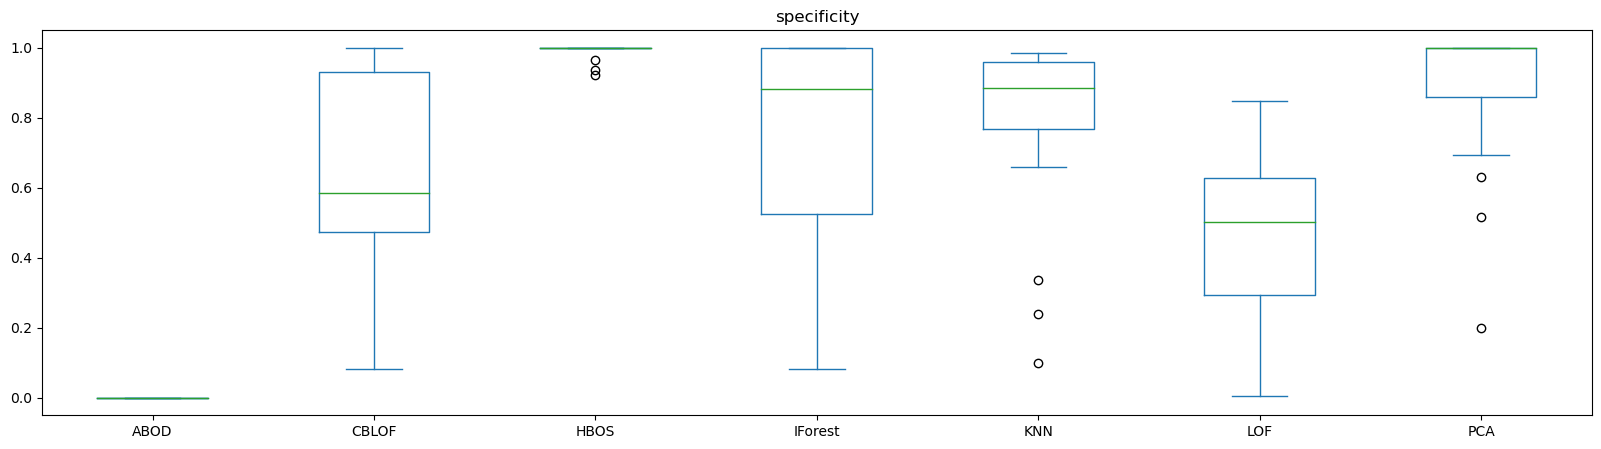

<Figure size 2000x300 with 0 Axes>

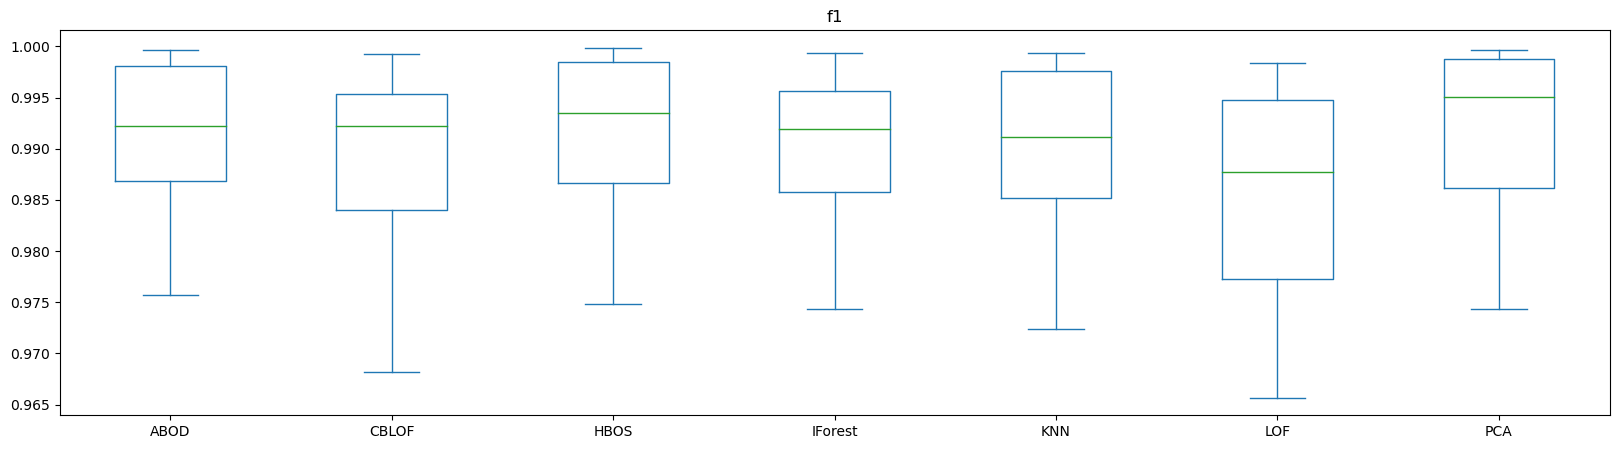

<Figure size 2000x300 with 0 Axes>

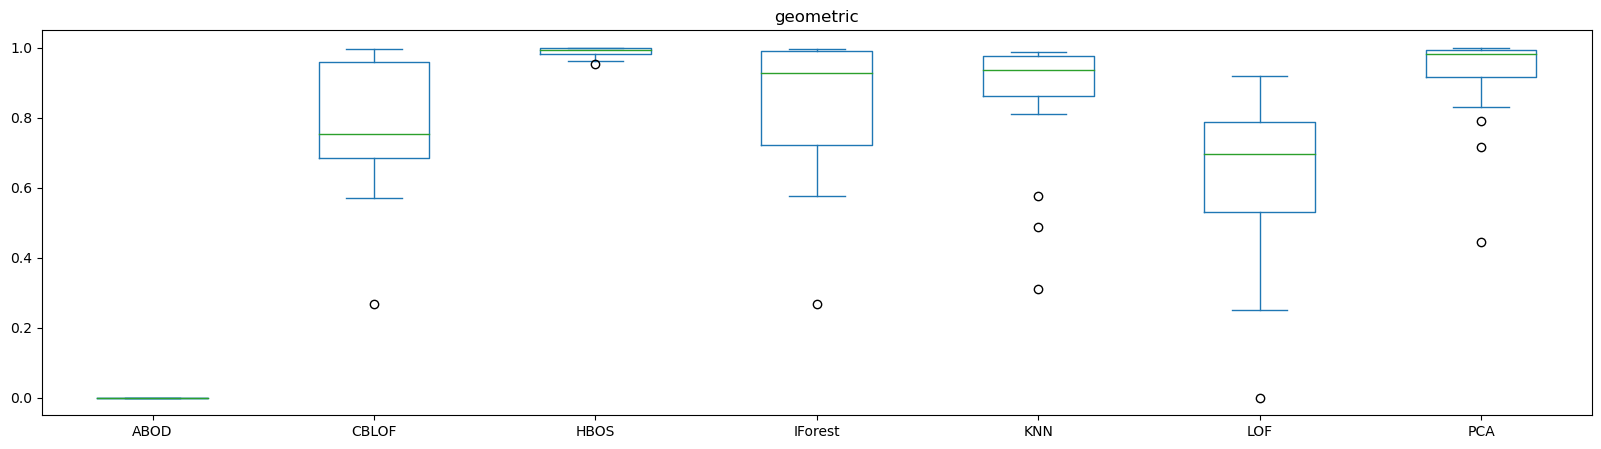

<Figure size 2000x300 with 0 Axes>

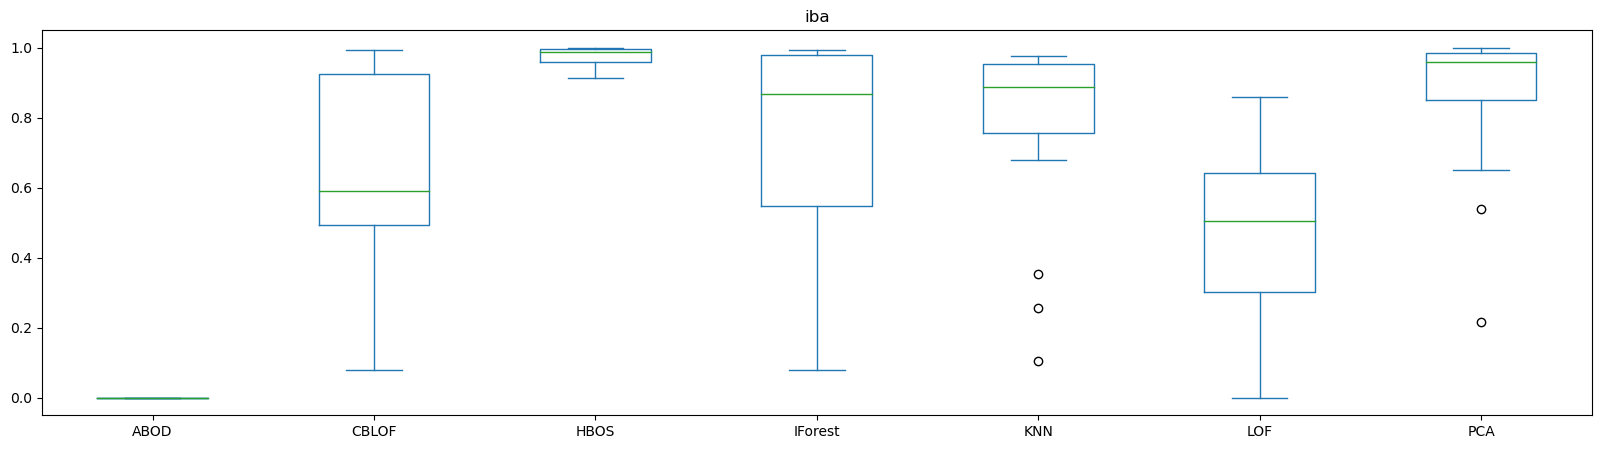

<Figure size 2000x300 with 0 Axes>

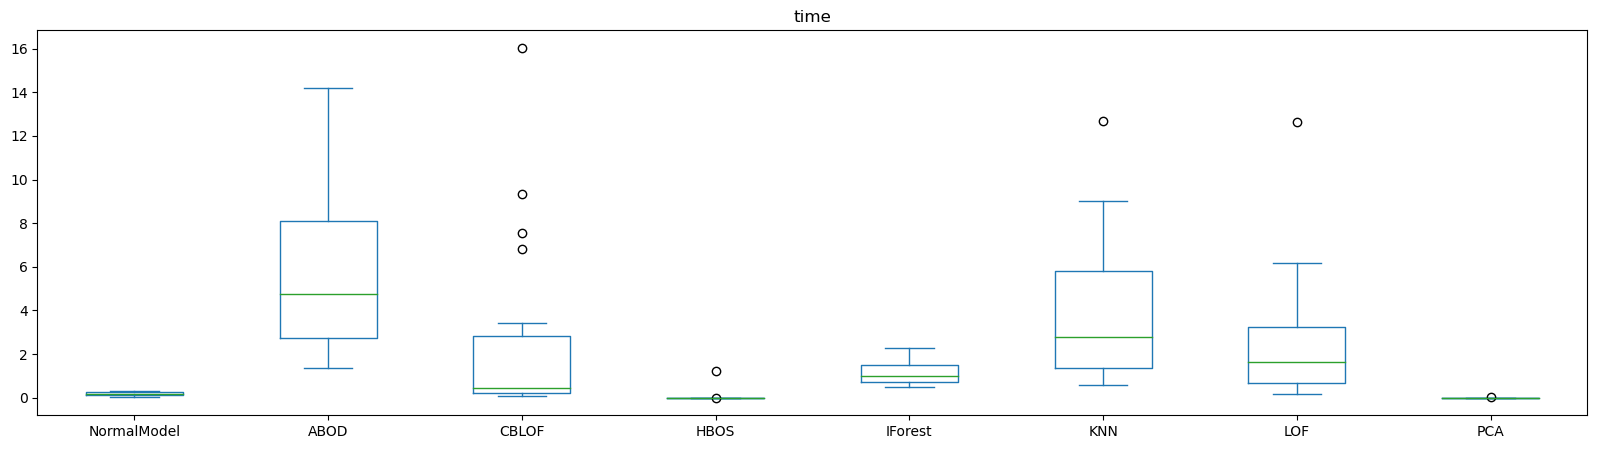

In [ ]:
types = ['contamination', 'precision', 'recall','specificity', 'f1', 'geometric', 'iba', 'time']
tmp = stats#.sum(axis=0)
for type in types:
    curr = tmp[[col for col in stats.columns if col.endswith(type)]].copy()
    
    # curr.index = curr.index.map(lambda x: pathlib.Path(x).name).astype('category')
    curr.columns = [col.replace(f'_{type}', '') for col in curr.columns]
    fig = plt.figure(figsize=(20, 3))
#     curr.plot(kind='box', figsize=(20, 3), title=type)
    try:
         curr.astype('float').plot(kind='box', figsize=(20,5), title=type)
    except Exception as e:
         continue
    plt.show()

In [ ]:
curr

,NormalModel_contamination,ABOD_contamination,CBLOF_contamination,HBOS_contamination,IForest_contamination,KNN_contamination,LOF_contamination,PCA_contamination
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-193.206.128.174.csv,0.047499,0.0,0.010049,0.000659,0.009994,0.004942,0.008456,0.010049
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-192.108.46.146.csv,0.003922,0.0,0.007099,0.003784,0.007099,0.00337,0.003591,0.004226
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2001:1458:302:27::2.csv,0.025306,0.0,0.010036,0.000476,0.010036,0.006186,0.006099,0.009993
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2a00:139c:5:585::3.csv,0.005667,0.0,0.008565,0.003288,0.008565,0.004066,0.00398,0.008479
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-62.40.126.184.csv,0.021735,0.0,0.009998,0.00823,0.009998,0.003535,0.009086,0.009998
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-188.1.144.222.csv,0.015524,0.0,0.010027,0.007734,0.009778,0.004889,0.009033,0.010027
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-192.108.47.3.csv,0.003562,0.0,0.008395,0.001326,0.008395,0.002651,0.003397,0.003618
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2001:1458:302:38::1.csv,0.003338,0.0,0.006807,0.000043,0.006633,0.00091,0.002254,0.000217
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-131.154.254.11.csv,0.002699,0.0,0.005729,0.000055,0.005509,0.002093,0.006666,0.003746
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2001:760:4205:254::12.csv,0.003046,0.0,0.008037,0.003299,0.006176,0.003553,0.007276,0.004399


In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
HTML(stats.to_html())

,num_samples,NormalModel_contamination,ABOD_contamination,ABOD_precision,ABOD_recall,ABOD_spscificity,ABOD_f1,ABOD_geometric,ABOD_iba,ABOD_time,CBLOF_contamination,CBLOF_precision,CBLOF_recall,CBLOF_spscificity,CBLOF_f1,CBLOF_geometric,CBLOF_iba,CBLOF_time,HBOS_contamination,HBOS_precision,HBOS_recall,HBOS_spscificity,HBOS_f1,HBOS_geometric,HBOS_iba,HBOS_time,IForest_contamination,IForest_precision,IForest_recall,IForest_spscificity,IForest_f1,IForest_geometric,IForest_iba,IForest_time,KNN_contamination,KNN_precision,KNN_recall,KNN_spscificity,KNN_f1,KNN_geometric,KNN_iba,KNN_time,LOF_contamination,LOF_precision,LOF_recall,LOF_spscificity,LOF_f1,LOF_geometric,LOF_iba,LOF_time,PCA_contamination,PCA_precision,PCA_recall,PCA_spscificity,PCA_f1,PCA_geometric,PCA_iba,PCA_time
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-193.206.128.174.csv,18211,0.047499,0.0,1.0,0.952501,0.0,0.975673,0.0,0.0,3.132114,0.010049,0.985964,0.952776,0.518119,0.967686,0.701209,0.513065,0.167383,0.000659,0.99935,0.95316,0.999969,0.975377,0.976283,0.948668,0.001547,0.009939,0.992141,0.96244,0.999623,0.974358,0.980848,0.958486,0.934806,0.004942,0.994941,0.956345,0.889224,0.973581,0.922162,0.85609,1.519896,0.008456,0.987962,0.952611,0.510298,0.968668,0.696002,0.505845,0.485612,0.010049,0.992077,0.96255,0.99962,0.974375,0.980903,0.958603,0.002506
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-192.108.46.146.csv,36203,0.003922,0.0,1.0,0.996078,0.0,0.998035,0.0,0.0,12.396217,0.007099,0.996834,0.996823,0.555706,0.996368,0.743323,0.576902,0.149293,0.003784,0.999867,0.999862,0.999999,0.999863,0.999931,0.999848,0.001987,0.007099,0.996834,0.996823,0.555706,0.996368,0.743323,0.576902,1.100109,0.00337,0.999371,0.999282,0.975491,0.999309,0.987314,0.977107,9.49066,0.003591,0.997844,0.997735,0.731731,0.997785,0.854293,0.749231,7.919676,0.004226,0.999696,0.999696,0.928408,0.999691,0.963382,0.934721,0.003492
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2001:1458:302:27::2.csv,23117,0.025306,0.0,1.0,0.974694,0.0,0.987185,0.0,0.0,4.147653,0.009906,0.991415,0.980966,0.818238,0.985054,0.895765,0.815451,0.120536,0.000476,0.999533,0.97517,0.999988,0.98697,0.987501,0.972738,0.001639,0.009993,0.993953,0.984687,0.999845,0.987949,0.992236,0.98304,1.069935,0.006186,0.995217,0.980707,0.985981,0.98647,0.98334,0.966448,2.447488,0.006099,0.987681,0.968595,0.005944,0.978045,0.0,0.0,1.054624,0.009993,0.993953,0.984687,0.999845,0.987949,0.992236,0.98304,0.003045
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-2a00:139c:5:585::3.csv,23117,0.005667,0.0,1.0,0.994333,0.0,0.997159,0.0,0.0,5.147517,0.008565,0.99711,0.997102,0.664514,0.996809,0.813398,0.683621,0.094248,0.003288,0.99862,0.997621,0.999992,0.997935,0.998806,0.997376,0.002377,0.008565,0.99711,0.997102,0.664514,0.996809,0.813398,0.683621,0.808612,0.004066,0.998554,0.998053,0.957613,0.998213,0.97762,0.959607,2.899461,0.00398,0.997783,0.997102,0.848423,0.997354,0.919714,0.858451,1.628825,0.008479,0.996333,0.996496,0.630706,0.99615,0.792043,0.650279,0.003045
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-62.40.126.184.csv,36209,0.021735,0.0,1.0,0.978265,0.0,0.989013,0.0,0.0,7.897529,0.009998,0.994601,0.988263,0.999881,0.990398,0.994054,0.986996,0.150387,0.00823,0.994886,0.986495,0.999888,0.989492,0.993168,0.985062,0.001909,0.009998,0.994601,0.988263,0.999881,0.990398,0.994054,0.986996,1.451187,0.003535,0.996844,0.981469,0.953226,0.988057,0.967243,0.9382,4.896693,0.009086,0.988824,0.979121,0.551074,0.983338,0.733387,0.56088,3.137307,0.009998,0.994601,0.988263,0.999881,0.990398,0.994054,0.986996,0.003615
results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-188.1.144.222.csv,36202,0.015524,0.0,1.0,0.984476,0.0,0.992177,0.0,0.0,9.486311,0.010027,0.996449,0.994503,0.999944,0.995087,0.99722,0.993906,0.154322,0.007734,0.996119,0.99221,0.999939,0.993499,0.996067,0.991383,0.001897,0.009778,0.996381,0.994254,0.999943,0.994898,0.997095,0.993632,1.246914,0.004889,0.995808,0.988095,0.870636,0.991164,0.927471,0.870306,6.130799,0.009033,0.989027,0.984

In [ ]:
unprocessed = []

In [ ]:
for i, path in enumerate(dataset):
    df = load_df(path)
    
    start = datetime.now()

    start = datetime.now()
    try:
        current = process(df)
    except RuntimeError as e:
        unprocessed.append(path)
        current = df['value'].apply(lambda x: np.nan).rename(model_name)
    end = datetime.now()

    duration = end - start
    total_times.append(duration.total_seconds())
    per_sample_times.append(duration.total_seconds() / len(df))

    file_path = pathlib.Path(path[18:])
    file_dir = benchmark_dir / file_path.parent
    
    if not file_dir.exists():
        file_dir.mkdir(parents=True)

    out_path = file_dir / file_path.name
    
    current.index = current.index.rename('timestamp')
    if out_path.exists():
        existing = load_df(out_path)
        current = pd.concat([existing, current], axis=1)

    current.to_csv(out_path)
    clear_output(wait=True)


/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [14]:
df=load_df(dataset[1])

In [15]:
for model in models:
        model_name = model.__class__.__name__
        model = copy.deepcopy(model)
        model.fit(df['rtt'].values.reshape(-1, 1))
        df[f'{model_name}'] = pred = model.predict(df['rtt'].values.reshape(-1, 1))

/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/msi/miniconda3/envs/pyod/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/hom

In [13]:
dataset[1]

'results/benchmark/RTT/2a00:139c:5:585:0:41:2:12-192.108.46.146.csv'

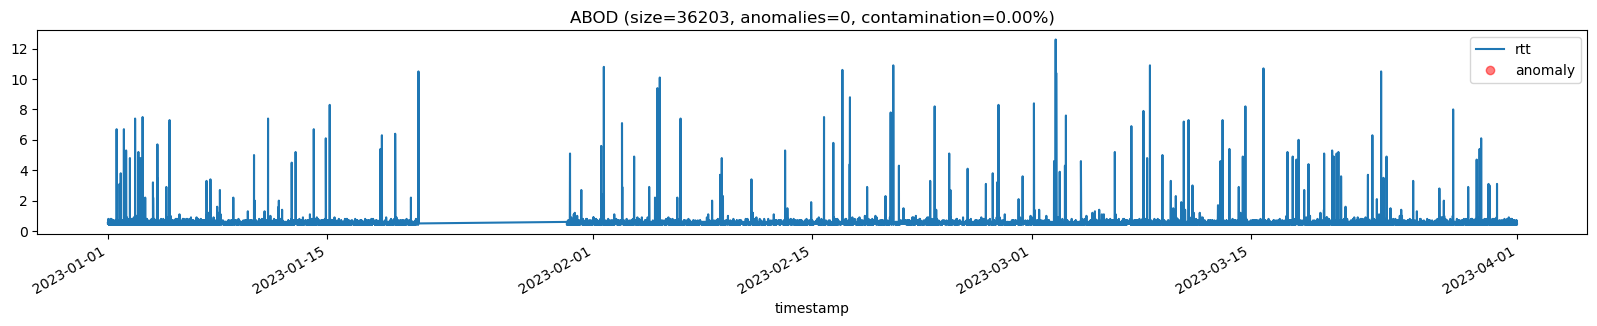

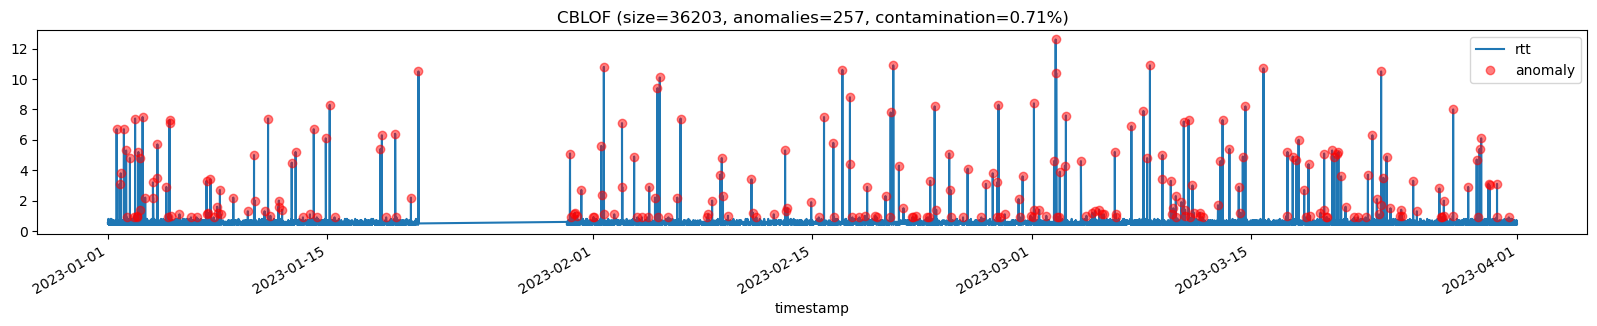

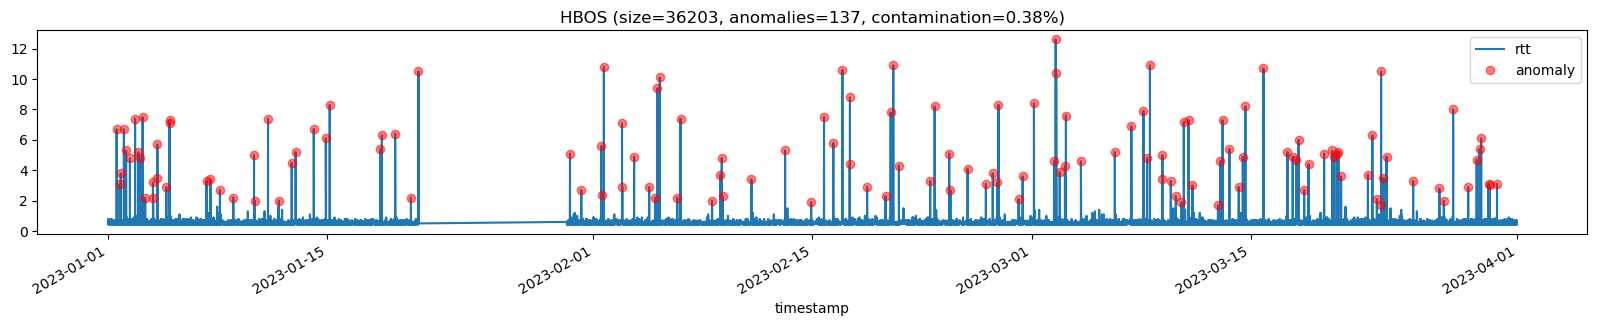

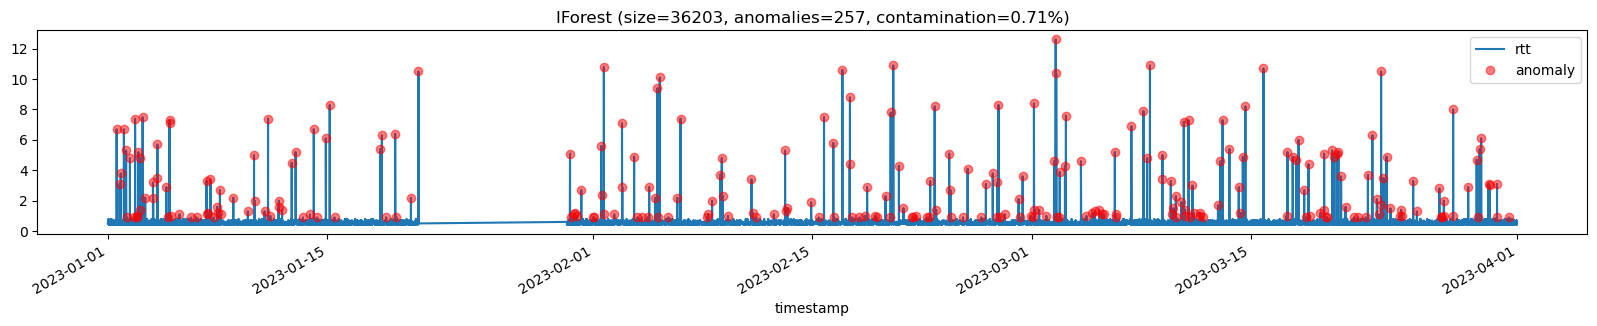

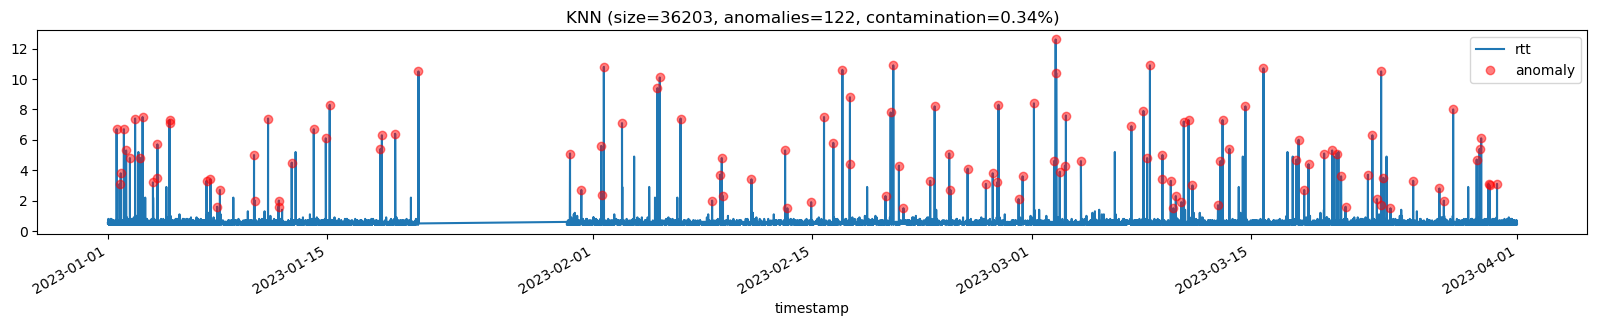

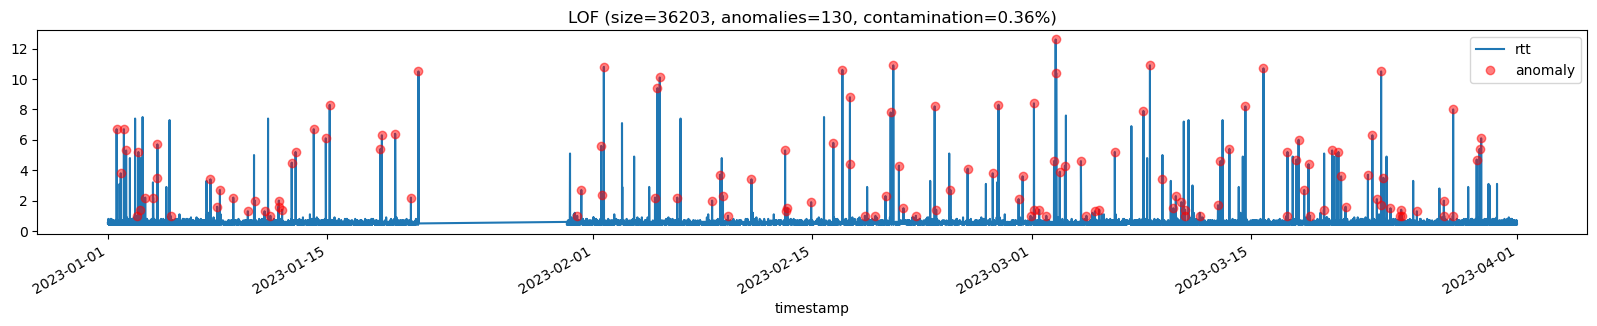

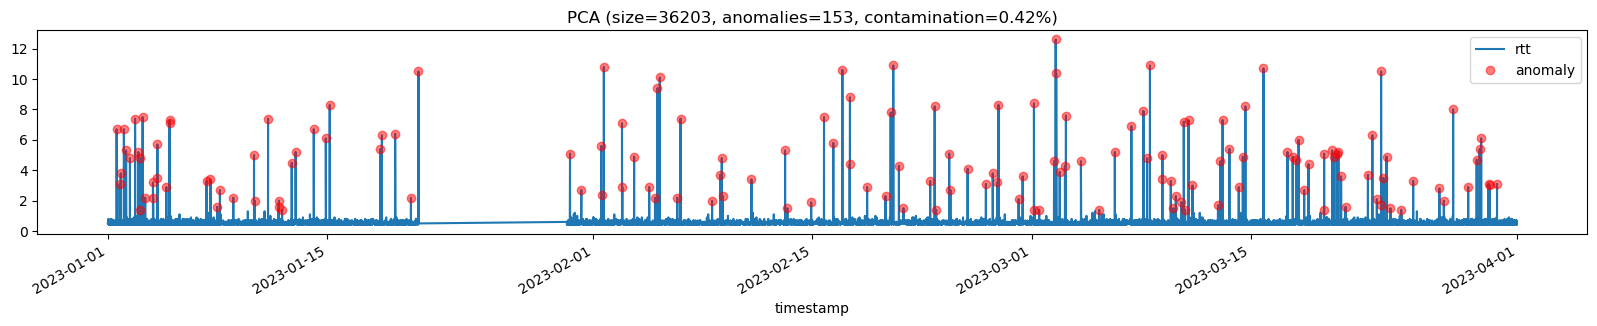

In [16]:
for model in models:
        model_name = model.__class__.__name__
        fig = plt.figure(figsize=(20, 3))
        ax = plt.gca()
        df['rtt'].plot(ax=ax, label='rtt')
        df[df[model_name] == 1]['rtt'].plot(ax=ax, style='ro', label='anomaly', alpha=0.5)
        plt.legend()
        plt.title(f"{model_name} (size={df.shape[0]}, anomalies={df[model_name].sum()}, contamination={100*df[model_name].sum()/len(df):.2f}%)")
        plt.savefig(f"results/figures/_{model_name}_anomalies.png", format='png', )
        plt.show()